# 프로젝트 : 얼굴을 인식하여 캐릭터 씌우기

## Face Detection vs Face Recognition

패키지 설치
> pip install mediapipe
> 안될시, pip install --user mediapipe

In [1]:
import mediapipe as mp

In [ ]:
## 원본

import cv2
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# For static images:
IMAGE_FILES = []
with mp_face_detection.FaceDetection(
    model_selection=1, min_detection_confidence=0.5) as face_detection:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face detections of each face.
    if not results.detections:
      continue
    annotated_image = image.copy()
    for detection in results.detections:
      print('Nose tip:')
      print(mp_face_detection.get_key_point(
          detection, mp_face_detection.FaceKeyPoint.NOSE_TIP))
      mp_drawing.draw_detection(annotated_image, detection)
    cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_face_detection.FaceDetection(
    model_selection=0, min_detection_confidence=0.5) as face_detection:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image)

    # Draw the face detection annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.detections:
      for detection in results.detections:
        mp_drawing.draw_detection(image, detection)
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Face Detection', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

In [3]:
## 프로젝트용 - 웹켐이 아닌 동영상에서로~
#눈코입에 동그라미 씌움

import cv2
import mediapipe as mp

#얼굴을 찾고, 찾은 얼굴에 표시를 해주기 위한 변수 정의
mp_face_detection = mp.solutions.face_detection #얼굴 검출을 위한 face_detection 모듈을 사용
mp_drawing = mp.solutions.drawing_utils # 얼굴의 특징을 그리기 위한 drawing_utils 모듈을 사용

#동영상 파일열기
cap = cv2.VideoCapture('face_video.mp4')

#model_selection=0 or 1 -> 근거리, 5미터정도이내 //min_detection_confidence = 임계치? (0~1)
with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.7) as face_detection:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image)

        # Draw the face detection annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.detections:
            #6개 특징: 오른쪽눈, 왼쪽눈, 코끝부분, 입중심, 오른쪽귀, 왼쪽귀(귀구슬점, 이주)
            for detection in results.detections:
                #mp_drawing.draw_detection(image, detection) #얼굴에사각형그려줌
                #print(detection) #6개특징뽑아줌
                
                #특정 위치 가져오기
                keypoints = detection.location_data.relative_keypoints
                right_eye =keypoints[0]#오른쪽눈
                left_eye = keypoints[1]#왼쪽눈
                nose_tip = keypoints[2]#코끝부분
                
                h,w, _ = image.shape #height, width, channel : 이미지로부터 세로,가로크기 가져옴
                right_eye = (int(right_eye.x * w), int(right_eye.y*h)) #이미지 내에서 실제좌표(x,y)
                left_eye = (int(left_eye.x * w), int(left_eye.y*h)) #이미지 내에서 실제좌표(x,y)
                nose_tip = (int(nose_tip.x * w), int(nose_tip.y*h))
                
                #양 눈에 동그라미 그리기
                cv2.circle(image, right_eye, 50, (255,0,0),10, cv2.LINE_AA) #파란색
                cv2.circle(image, left_eye, 50, (0,255,0),10, cv2.LINE_AA) #초록색
                #코에 동그라미 그리기
                cv2.circle(image, nose_tip, 75, (0,255,255),10, cv2.LINE_AA) #노란색

        # Flip the image horizontally for a selfie-view display.
        cv2.imshow('MediaPipe Face Detection',cv2.resize(image,None,fx=0.5, fy=0.5))
        
        if cv2.waitKey(1)  == ord('q'):
              break
                
cap.release()
cv2.destroyAllWindows()

In [5]:
## 프로젝트용 - 웹켐이 아닌 동영상에서로~
#캐릭터 씌우기

import cv2
import mediapipe as mp

def overlay(image,x,y,w,h,overlay_image):
    #대상이미지(3채널),x,y,width,height, 덮어씌울이미지(4채널)
    alpha =overlay_image[:,:,3] #BGRA
    mask_image = alpha /255 #0~255 ->255로 나누면 0~1사이의 값(1=불투명, 0=완전투명)
    #(255,255) -> mask_image = (1,1)
    #(255,0) -> mask_image = (1,0)
    #(255,x) -> mask_image = (1,0.3)
    #완전투명한영역은(=0) 대상이미지에서 쓰고, 완전불투명한영역은(=1)오버레이이미지에서쓴다고 이해
    
    #1 - mask_image?
    #(0,0)
    #(0,1)
    #(0,0.7)
    
    for c in range(0,3): #channel BGR
        image[y-h:y+h, x-w:x+w, c] = (overlay_image[:,:,c]*mask_image) + (image[y-h:y+h, x-w:x+w, c]*(1-mask_image)) 
    

#얼굴을 찾고, 찾은 얼굴에 표시를 해주기 위한 변수 정의
mp_face_detection = mp.solutions.face_detection #얼굴 검출을 위한 face_detection 모듈을 사용
mp_drawing = mp.solutions.drawing_utils # 얼굴의 특징을 그리기 위한 drawing_utils 모듈을 사용

#동영상 파일열기
cap = cv2.VideoCapture('face_video.mp4')

#이미지 불러오기
image_right_eye = cv2.imread('right_eye.png',cv2.IMREAD_UNCHANGED)#100X100
image_left_eye = cv2.imread('left_eye.png',cv2.IMREAD_UNCHANGED)#100X100
image_nose = cv2.imread('nose.png',cv2.IMREAD_UNCHANGED)#300X100(가로,세로)

#model_selection=0 or 1 -> 근거리, 5미터정도이내 //min_detection_confidence = 임계치? (0~1)
with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.7) as face_detection:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image)

        # Draw the face detection annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.detections:
            #6개 특징: 오른쪽눈, 왼쪽눈, 코끝부분, 입중심, 오른쪽귀, 왼쪽귀(귀구슬점, 이주)
            for detection in results.detections:
                #mp_drawing.draw_detection(image, detection) #얼굴에사각형그려줌
                #print(detection) #6개특징뽑아줌
                
                #특정 위치 가져오기
                keypoints = detection.location_data.relative_keypoints
                right_eye =keypoints[0]#오른쪽눈
                left_eye = keypoints[1]#왼쪽눈
                nose_tip = keypoints[2]#코끝부분
                
                h,w, _ = image.shape #height, width, channel : 이미지로부터 세로,가로크기 가져옴
                right_eye = (int(right_eye.x * w)-20, int(right_eye.y*h)-100) #이미지 내에서 실제좌표(x,y)
                left_eye = (int(left_eye.x * w)+20, int(left_eye.y*h)-100) #이미지 내에서 실제좌표(x,y)
                nose_tip = (int(nose_tip.x * w), int(nose_tip.y*h))
                
                #각 특징에다가 이미지 그리기(그린 눈코입붙여넣을때)
#                 image[right_eye[1]-50:right_eye[1]+50, right_eye[0]-50:right_eye[0]+50] = image_right_eye
#                 image[left_eye[1]-50:left_eye[1]+50, left_eye[0]-50:left_eye[0]+50] = image_left_eye
#                 image[nose_tip[1]-50:nose_tip[1]+50, nose_tip[0]-150:nose_tip[0]+150] = image_nose
                
                #image,x,y,w,h,overlay_image
                overlay(image,*right_eye, 50,50,image_right_eye)
                overlay(image,*left_eye, 50,50,image_left_eye)
                overlay(image,*nose_tip, 150,50,image_nose)
    
    
        # Flip the image horizontally for a selfie-view display.
        cv2.imshow('MediaPipe Face Detection',cv2.resize(image,None,fx=0.5, fy=0.5))
        
        if cv2.waitKey(1)  == ord('q'):
              break
                
cap.release()
cv2.destroyAllWindows()

In [3]:
#크기,채널 확인하기
import cv2
image_right_eye = cv2.imread('right_eye.png',cv2.IMREAD_UNCHANGED)
image_right_eye.shape #(100, 100, 4)

(100, 100, 4)

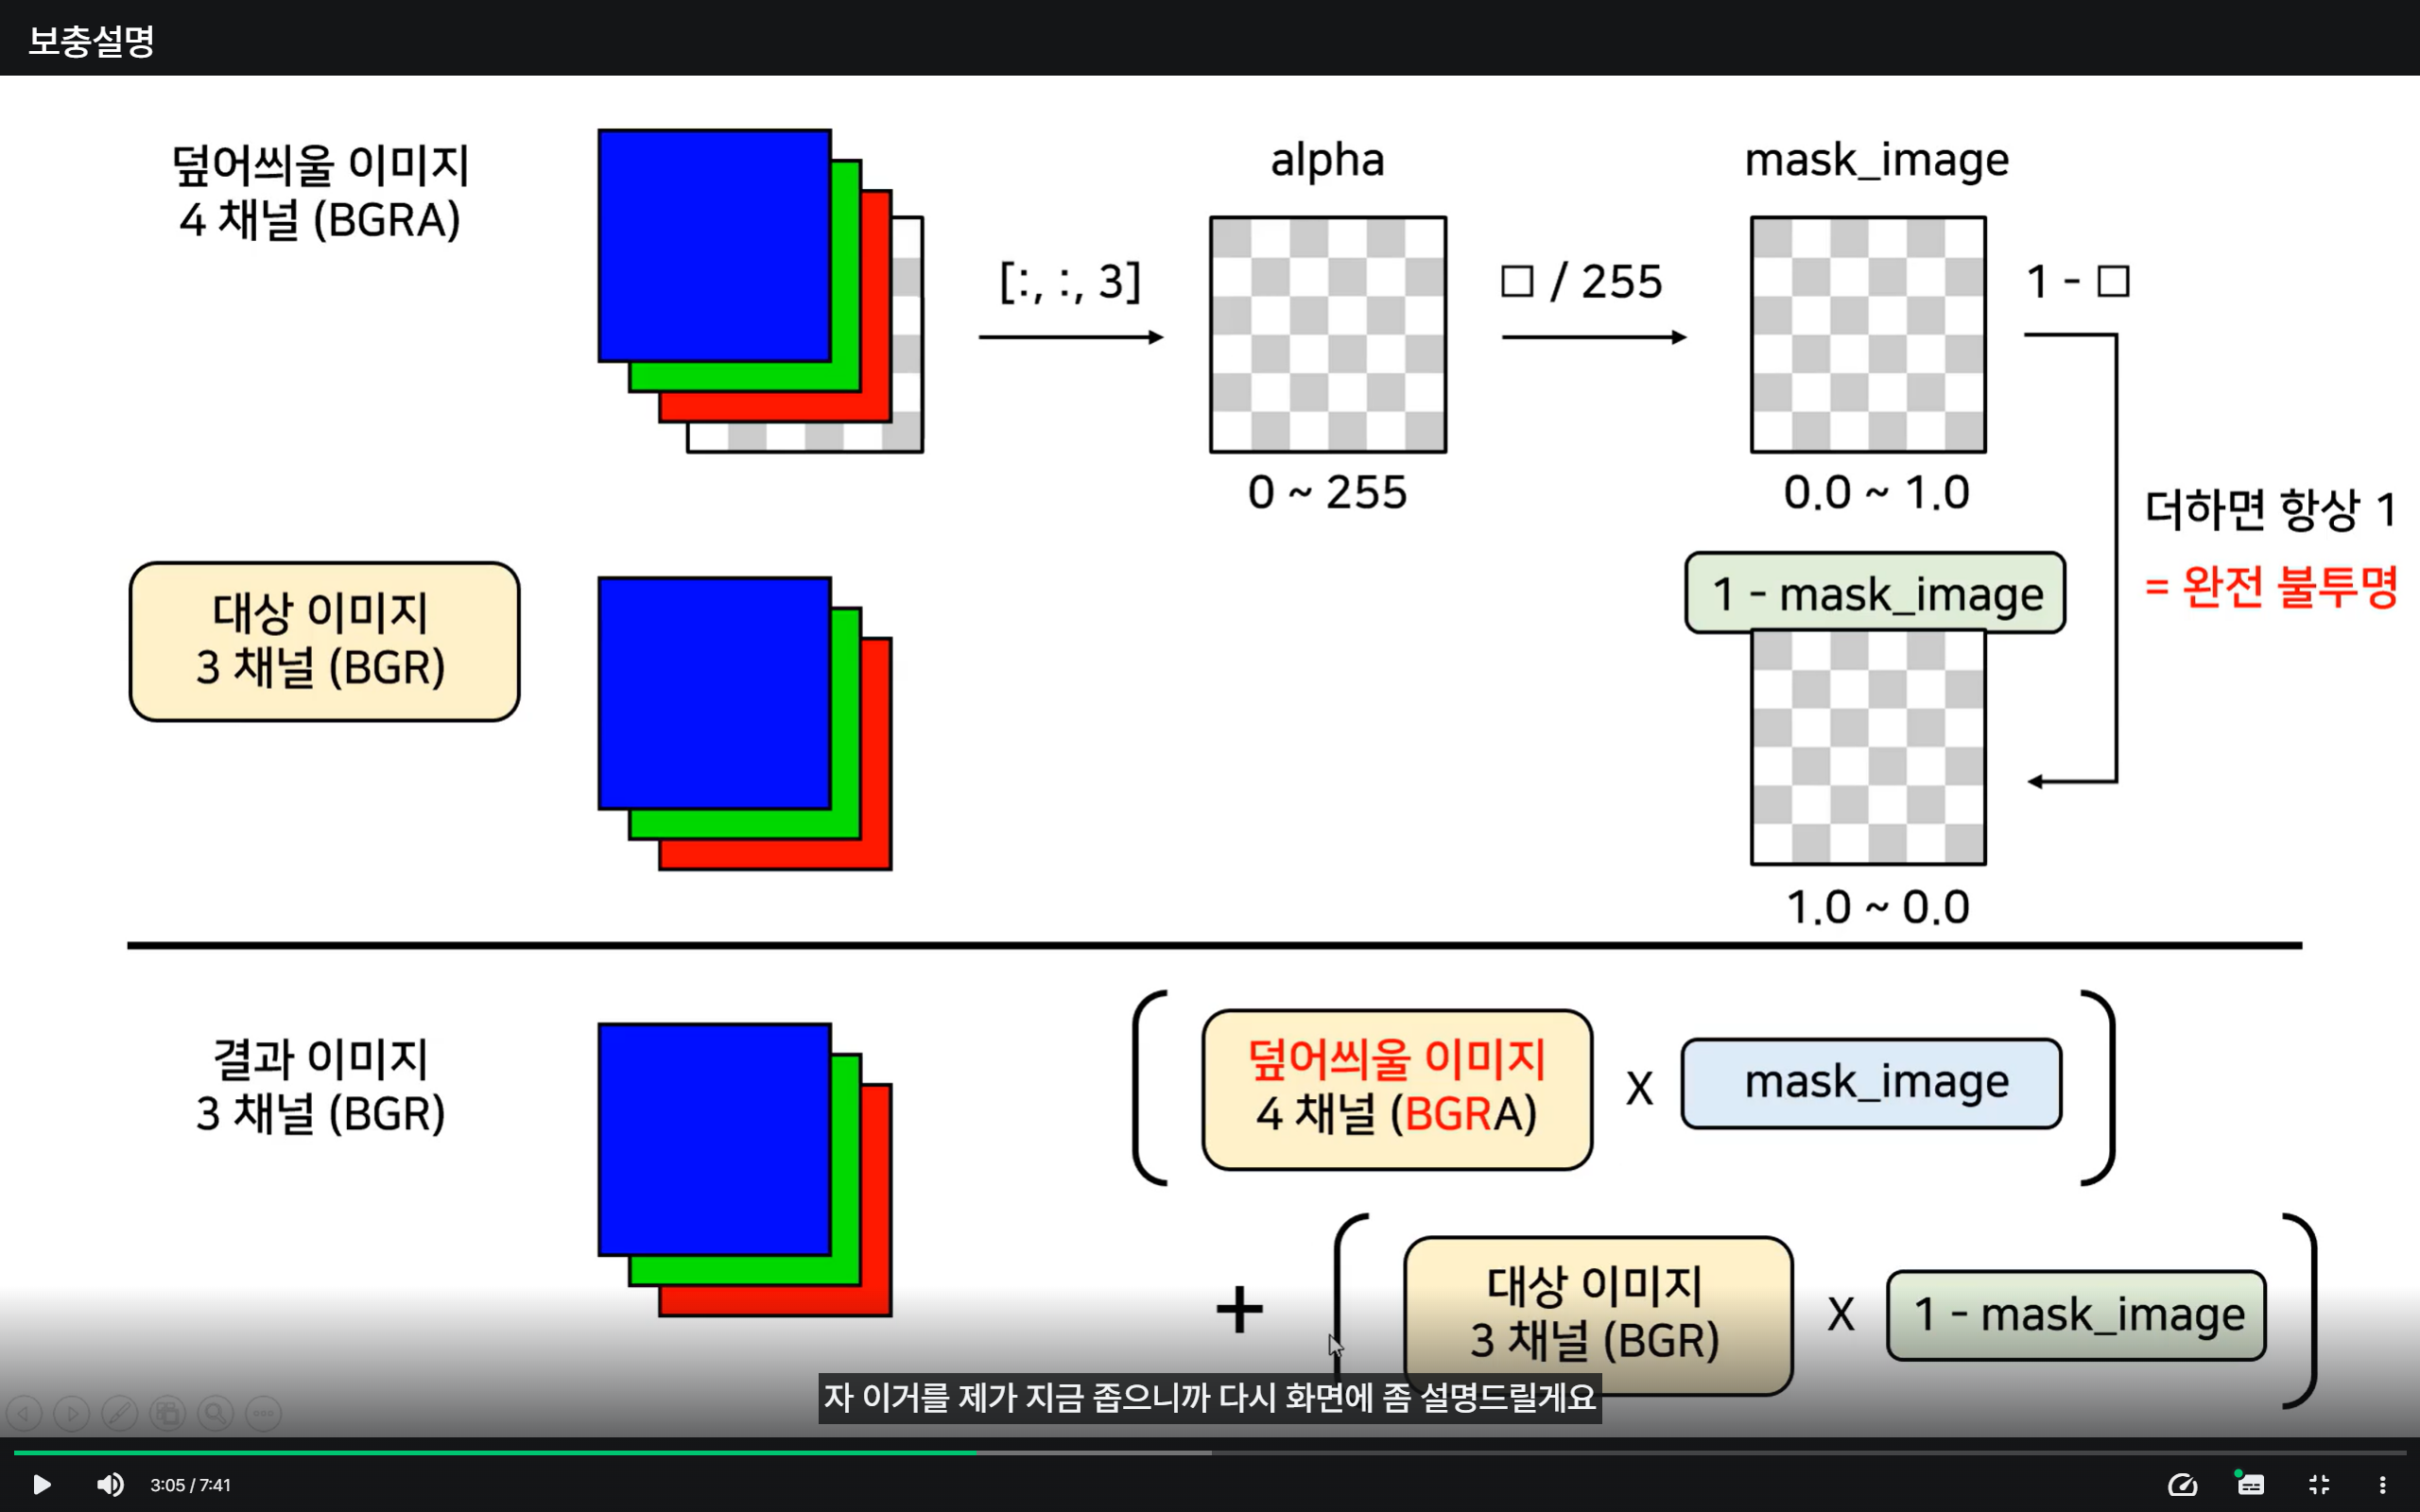

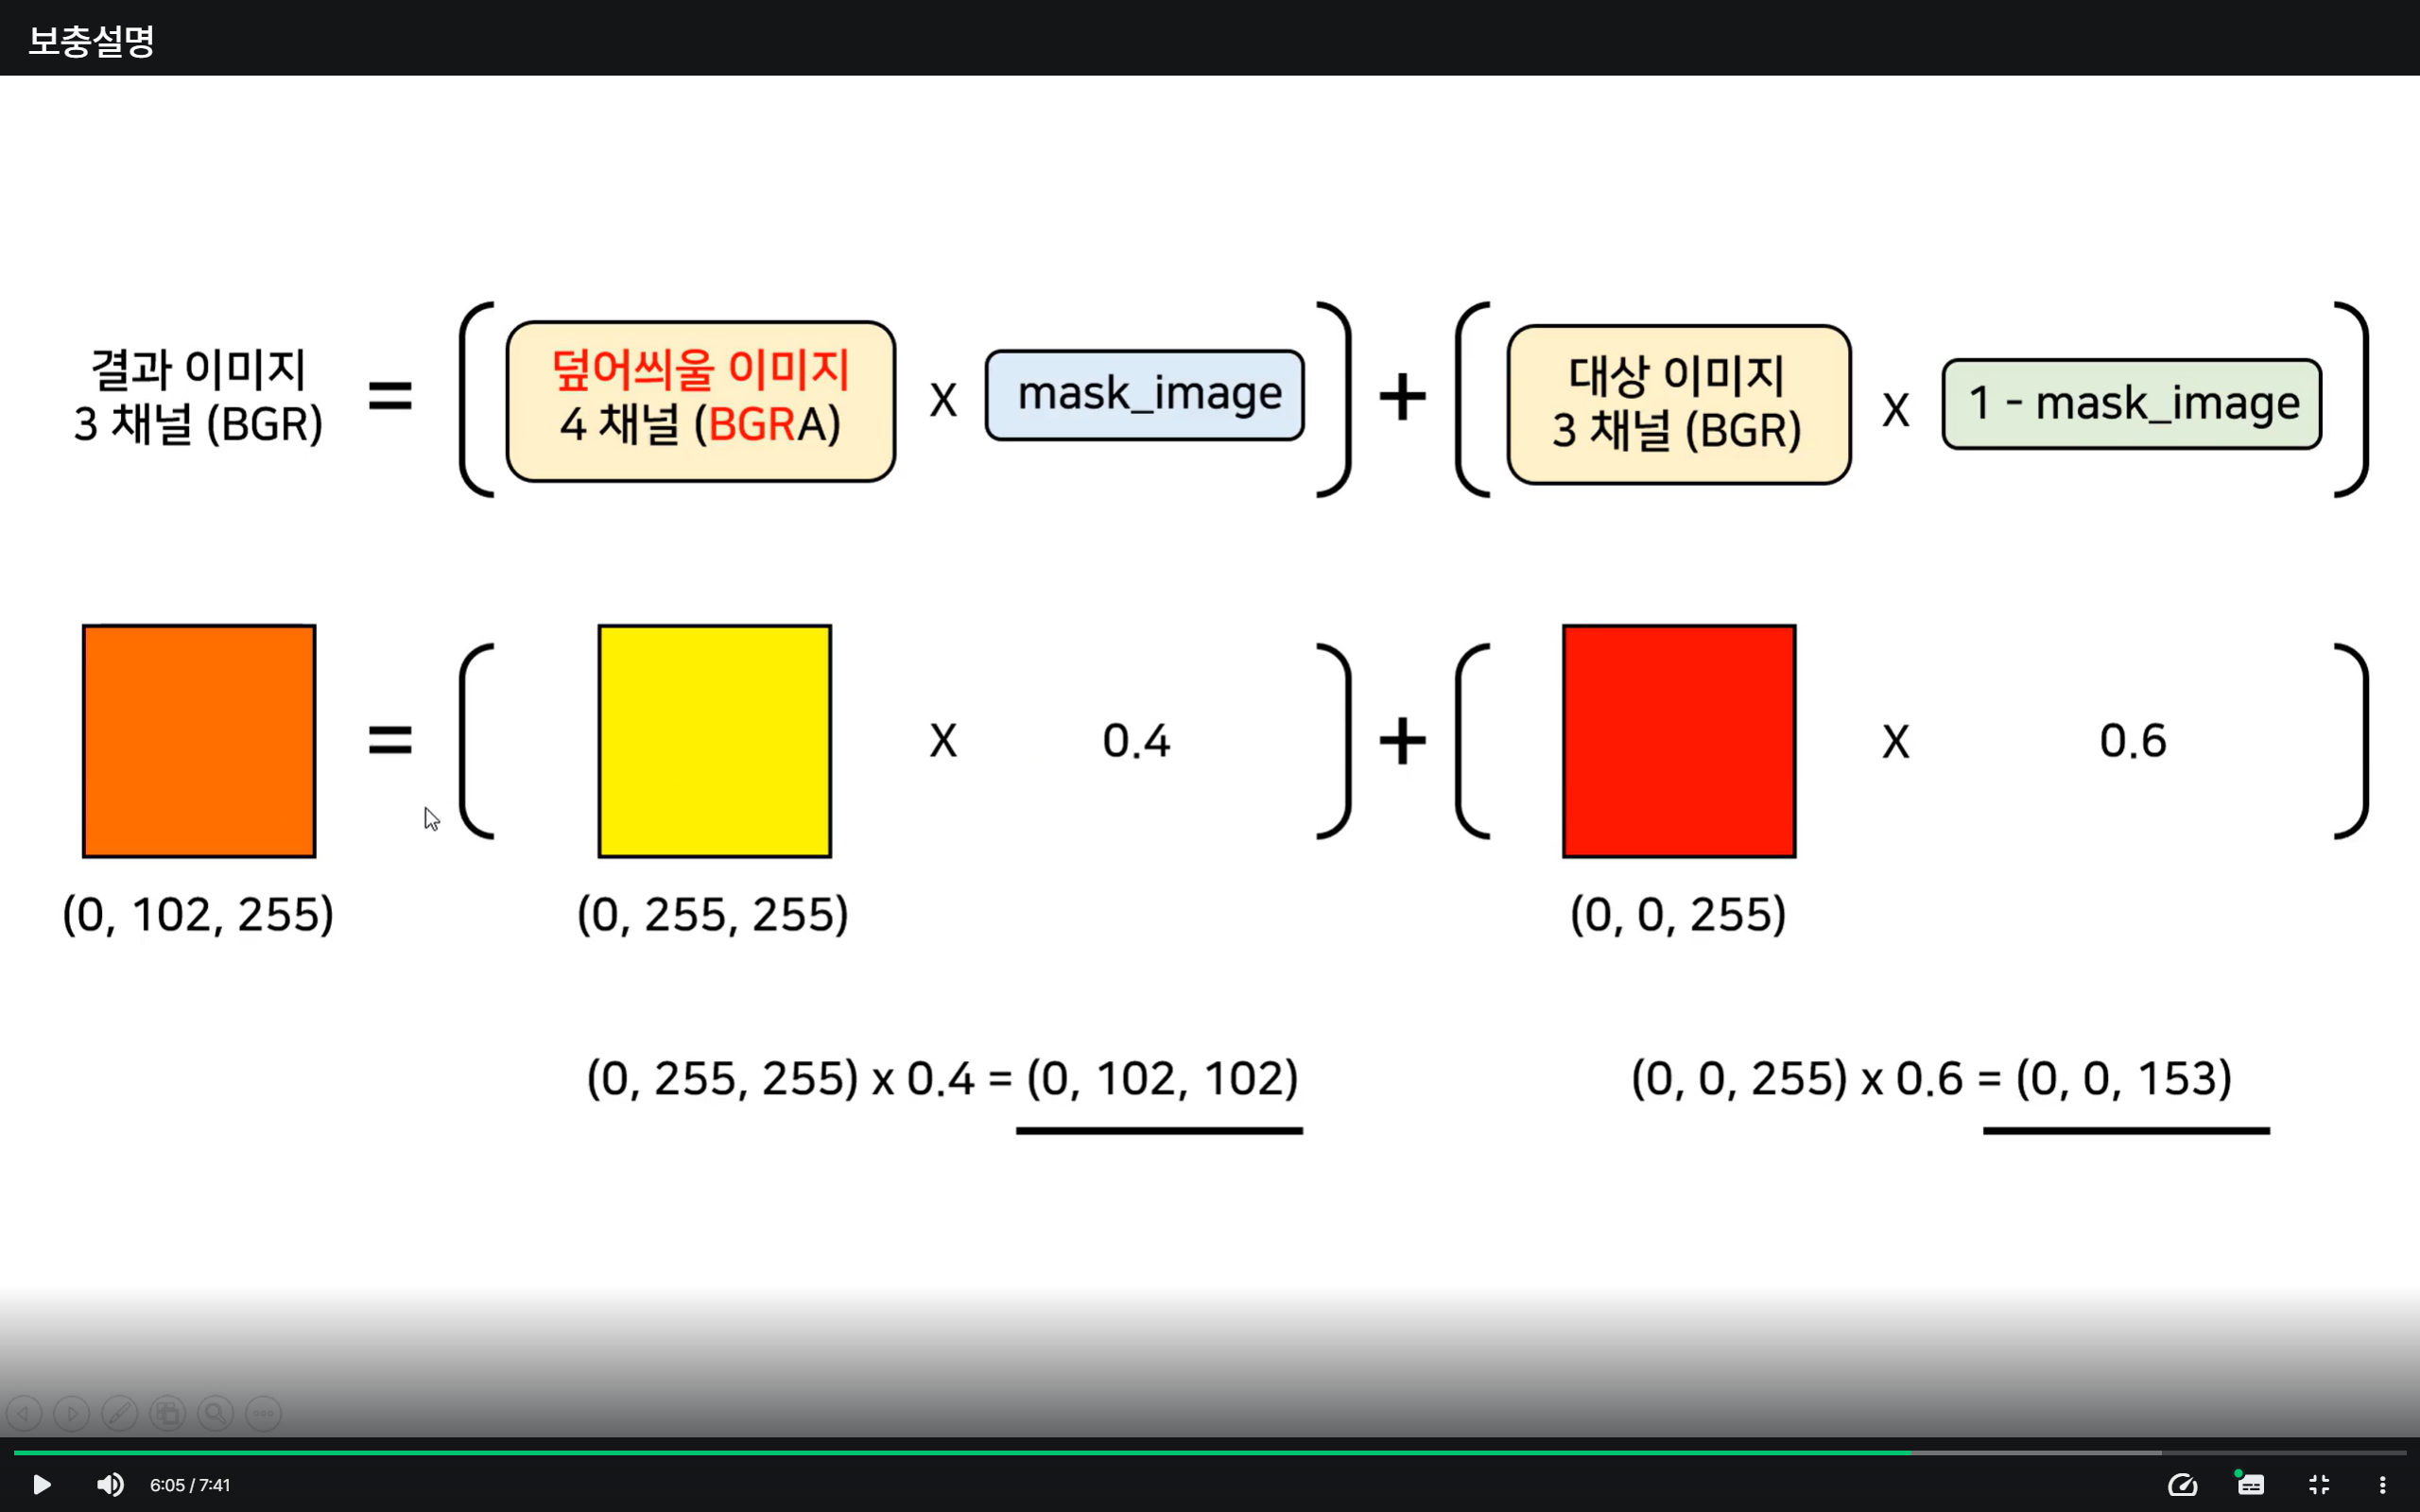